**Importando librerias**

In [114]:
##from google.colab import drive
##drive.mount('/content/drive')

In [115]:
print(f"Laboratorio N°4 - SIS420: Limachi Villarroel Alan Nicolas.")
print(f"Carrera: Ingeniería en Ciencias de la Computación.")

Laboratorio N°4 - SIS420: Limachi Villarroel Alan Nicolas.
Carrera: Ingeniería en Ciencias de la Computación.


**Preparación librerías y funciones para los modelos.** En este caso se prepararán las respectivas librerías para trabajar de forma más directa y sencilla con cada modelo, además de crear las funciones que se utilizarán para cada uno de estos modelos, creando así un código más legible, limpio, de forma que se entienda mejor cada algoritmo determinado.

**Determinación de las Librerías.**
Se explicará de forma simple el uso de estas librerías en este cuadernillo para un mejor entendimiento:
- import os: Interactuar con el sistema operativo.
- import pandas as pd: Manipular y analizar datos tabulares.
- import numpy as np: Computación numérica eficiente.
- from matplotlib import pyplot as plt: Visualizar datos y gráficos.
- from mpl_toolkits.mplot3d import Axes3D: Visualizar datos tridimensionales.
- from sklearn.linear_model import LinearRegression: Implementar regresión lineal.
- from sklearn.preprocessing import PolynomialFeatures: Crear características polinómicas.
- from sklearn.metrics import mean_squared_error: Evaluar el error cuadrático medio.
- from scipy import optimize: Optimizar funciones matemáticas.
from sklearn.model_selection import train_test_split: Dividir datos en entrenamiento y prueba.
- from sklearn.preprocessing import StandardScaler: Estandarizar características numéricas.
- import shutil: Manipular archivos y directorios.

In [116]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot as plt

#Para separa el Dataset 20% y 80% para diferentes pruebas
from sklearn.model_selection import train_test_split

# Modulo de optimizacion en scipy
from scipy import optimize

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

#Para las graficas
import seaborn as sns
import pandas as pd
import random

#Para el formato de la tabla de comparacion
from IPython.display import display, HTML

import matplotlib.pyplot as plt

**Determinación de las funciones.**

In [117]:
class Model:
    def __init__(self, dataset):
      self.dataset = self.prepocesarDataset(dataset)
      self.train_set, self.test_set = train_test_split(self.dataset, test_size=0.2, random_state=99)
      self.X_train, self.y_train = self.train_set.iloc[:, :-1], self.train_set.iloc[:, -1]
      self.X_test, self.y_test = self.test_set.iloc[:, :-1], self.test_set.iloc[:, -1]
      self.X_train = np.concatenate([np.ones((self.X_train.shape[0], 1)), self.X_train], axis=1)
      self.X_test = np.concatenate([np.ones((self.X_test.shape[0], 1)), self.X_test], axis=1)
      self.J = 0
    
    def normalizarCaracteristicas(self, X):
      if X.size == 0:
        raise ValueError("El conjunto de características está vacío.")
    
      X = np.array(X, dtype=float)  # Asegúrate de que sea un array de floats
      X = np.nan_to_num(X)  # Reemplaza NaNs por 0
    
      media = np.mean(X, axis=0)
      desviacion_estandar = np.std(X, axis=0)
      desviacion_estandar[desviacion_estandar == 0] = 1  # Evitar división por cero
    
      X_norm = (X - media) / desviacion_estandar
      return X_norm
    
    def graficarCosto(self, J):
      plt.plot(np.arange(len(J)), J, lw=2)
      plt.xlabel('Numero de iteraciones')
      plt.ylabel('Costo J')
    
    def calcularPorcentajeAcierto(self):
      predicciones = self.realizarPredicciones(self.X_test, self.theta)
      predicciones_redondeadas = np.round(predicciones)
      precision = np.mean(predicciones_redondeadas == self.y_test) * 100
      print("Precisión de las predicciones en el conjunto de prueba: {:.10f}%".format(precision))
    
    def prepocesarDataset(self, dataset):
      dataset = pd.read_csv(dataset, sep=',', header=0, decimal=',')
      columns_to_drop = ['Patient Id', 'Patient First Name', 'Family Name', "Father's name", 'Institute Name', 'Location of Institute', 'Gender', 'Inherited from father', 'Maternal gene', 'Parental consent', 'Folic acid details (peri-conceptional)', 'H/O serious maternal illness', 'Assisted conception IVF/ART', 'History of anomalies in previous pregnancies']
      dataset = dataset.drop(columns=columns_to_drop)
      dataset = dataset.dropna()
      
      datos = {}
      columnas = dataset.columns[dataset.dtypes == 'object'].tolist()
      for columna in columnas:
        datos[columna] = dataset[columna].drop_duplicates().values
      datos_num = {}
      for columna, valores in datos.items():
        indice_reemp = 0
        datos_num_col = {}
        for valor in valores:
          if valor not in datos_num_col and not pd.isnull(valor):
            datos_num_col[valor] = indice_reemp
            indice_reemp += 1
        if np.nan not in datos_num_col:
          datos_num_col[np.nan] = 0
        datos_num[columna] = datos_num_col
      for columna, d_n in datos_num.items():
        dataset[columna] = dataset[columna].replace(d_n)
      dataset = dataset.fillna(0)
      return dataset

**(1) Regresión Logística.** Se eligió un modelo one vs all debido a las características del dataset, siendo que éstas tenían una hipótesis representable de forma binaria (0 o 1, falso o verdadero).

**(a) Establecimiento de la clase y los métodos.**


* __init__(self, _dataset): El constructor de la clase que inicializa los datos del conjunto de entrenamiento y de prueba, y también inicializa los parámetros del modelo.

* entrenar(self): Este método entrena el modelo utilizando el descenso de gradiente. Normaliza las características, grafica los datos de entrenamiento, calcula los parámetros theta y el costo J, y luego grafica el costo en función del número de iteraciones.

* _normalizarCaracteristicas(self, X): Normaliza las características del conjunto de datos restando la media y dividiendo por la desviación estándar.

* _graficarCosto(self, J): Grafica el costo en función del número de iteraciones durante el entrenamiento.

* _funcionSigmoide(self, z): Calcula la función sigmoide para una matriz de entrada z.

* _funcionCosto(self, X, y, theta): Calcula el costo de la regresión logística dado un conjunto de datos X, etiquetas y y parámetros theta.

* descensoGradiente(self, X, y, theta, alpha, num_iter): Realiza el descenso de gradiente para encontrar los parámetros theta que minimizan el costo.

* graficarDatos(self, X, y): Grafica los datos de entrenamiento con dos clases.

* _preprocesarDataset(self, _dataset): Lee el conjunto de datos desde un archivo CSV, realiza el preprocesamiento necesario como la eliminación de duplicados y la conversión de datos categóricos a numéricos, y devuelve el conjunto de datos preprocesado.

* realizarPredicciones(self, X, theta): Realiza predicciones utilizando el modelo entrenado y los parámetros theta dados.

* calcularPorcentajeAcierto(self): Calcula el porcentaje de precisión del modelo en el conjunto de prueba y lo imprime.

In [118]:
class ModelLogistica(Model):
  def entrenar(self, regularizacion):
      self.lambda_ = 0.01 if regularizacion else 0
      self.X_test = self.normalizarCaracteristicas(self.X_test)
      self.X_train = self.normalizarCaracteristicas(self.X_train)
      self.theta = np.zeros(self.X_train.shape[1])
      self.theta, self.J = self.descensoGradiente(self.X_train, self.y_train, self.theta, self.lambda_, 1000)
      self.graficarCosto(self.J)
  
  def funcionSigmoide(self, z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))
  
  def funcionCosto(self, X, y, theta):
    m = y.size
    h = self.funcionSigmoide(X @ theta)
    h = np.clip(h, 1e-10, 1 - 1e-10)
    costo = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
    if self.lambda_ != 0:
      regularizacion = (self.lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)
      costo += regularizacion
    return costo
  
  def descensoGradiente(self, X, y, theta, lambda_, num_iteraciones):
    m = y.shape[0]
    theta = theta.copy()
    J_history = []
    for _ in range(num_iteraciones):
        h = self.funcionSigmoide(X @ theta)
        gradiente = (1 / m) * (X.T @ (h - y))
        if lambda_ != 0:
            regularizacion = (lambda_ / m) * theta
            regularizacion[0] = 0
            gradiente += regularizacion
        theta -= gradiente
        J_history.append(self.funcionCosto(X, y, theta))
    return theta, J_history
  
  def realizarPredicciones(self, X, theta):
    probabilidad = self.funcionSigmoide(X @ theta)
    predicciones = (probabilidad >= 0.5).astype(int)
    return predicciones
  
  def calcularPorcentajeAcierto(self):
    predicciones = self.realizarPredicciones(self.X_test, self.theta)
    predicciones_redondeadas = np.round(predicciones)
    precision = np.mean(predicciones_redondeadas == self.y_test) * 100
    print("Precisión de las predicciones en el conjunto de prueba: {:.10f}%".format(precision))

**(b) Realización de las predicciones.**

In [119]:
datasetLogistica = r"E:\5to_Semestre\IA_InteligenciaArticifial\Primer_Parcial-SIS420\train.csv"
lCR = ModelLogistica(datasetLogistica)

C:\Users\TODO LAPTOP\AppData\Local\Temp\ipykernel_14948\3649250539.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset[columna] = dataset[columna].replace(d_n)


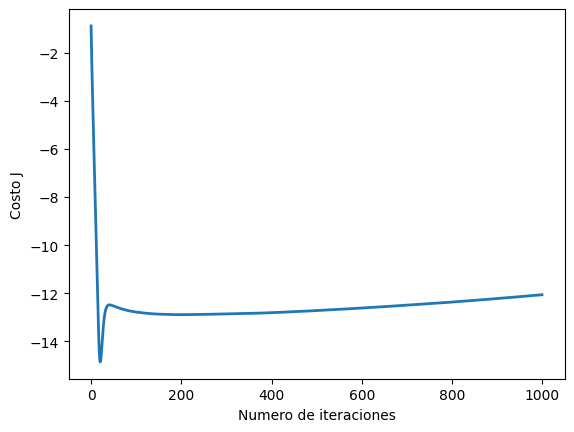

In [120]:
lCR.entrenar(True)

In [121]:
lCR.calcularPorcentajeAcierto()

Precisión de las predicciones en el conjunto de prueba: 31.7265556529%


In [122]:
print(lCR.lambda_)
print(lCR.descensoGradiente(lCR.X_train, lCR.y_train, lCR.theta, lCR.lambda_, 100)[0])

0.01
[ 0.00000000e+00 -1.35819691e+01 -3.19556769e+01  2.11239379e+01
 -1.04725313e+01 -1.79674752e+01 -8.21263854e+01  3.46146324e+01
 -1.04206270e+01 -1.46754158e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.56224057e+00
 -1.37317412e+01  3.50314862e+01  3.49668331e+00 -6.22109772e+00
  3.28233124e+01  2.59842424e+01  1.40625635e-01  1.08300011e+01
 -2.78860123e+01  2.50177729e+00  2.39359300e+00  2.80168341e+01
  1.43695348e+01  2.74854650e+01  9.36045321e+02]


**(2) Regresión One vs All.** Se eligió un modelo One vs All siendo que la última columna tenía clasificación.

**(a) Establecimiento de la clase y los métodos.**


* __init__(self, _dataset): El constructor de la clase que inicializa los datos del conjunto de entrenamiento y de prueba, y también inicializa los parámetros del modelo.

* entrenar(self): Este método entrena el modelo utilizando el descenso de gradiente. Normaliza las características, grafica los datos de entrenamiento, calcula los parámetros theta para cada clase, y luego grafica el costo en función del número de iteraciones.

* funcionCosto(self, theta, X, y, lambda_): Calcula el costo y el gradiente de la función de costo para la regresión logística con regularización.

* _funcionSigmoide(self, z): Calcula la función sigmoide para una matriz de entrada z.

* descensoGradiente(self, X, y, num_iteraciones): Realiza el descenso de gradiente para encontrar los parámetros theta que minimizan el costo para cada clase.

* _normalizarCaracteristicas(self, X): Normaliza las características del conjunto de datos restando la media y dividiendo por la desviación estándar.

* _graficarCosto(self, J): Grafica el costo en función del número de iteraciones durante el entrenamiento.

* graficarDatos(self, X, y): Grafica los datos de entrenamiento con una característica y la magnitud del terremoto.

* _preprocesarDataset(self, _dataset): Lee el conjunto de datos desde un archivo CSV, realiza el preprocesamiento necesario como la eliminación de duplicados y la conversión de datos categóricos a numéricos, y devuelve el conjunto de datos preprocesado.

* _preprocesarEspecial(self, _dataset): Realiza un preprocesamiento especial en el conjunto de datos, como la conversión de tipos de datos, el cálculo de la diferencia de tiempo, y la eliminación de columnas innecesarias.

* realizarPredicciones(self, X, theta): Realiza predicciones utilizando el modelo entrenado y los parámetros theta para cada clase.

* calcularPorcentajeAcierto(self): Calcula el porcentaje de precisión del modelo en el conjunto de prueba y lo imprime.

In [123]:
class ModelOnevsAll(Model):
    
    def entrenar(self, regularizacion):
        self.lambda_ = 0.01 if regularizacion else 0
        self.X_test = self.normalizarCaracteristicas(self.X_test)
        self.X_train = self.normalizarCaracteristicas(self.X_train)
        self.theta = self.descensoGradiente(self.X_train, self.y_train, self.lambda_, 1000)
    
    def funcionSigmoide(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def funcionCosto(self, theta, X, y, lambda_):
      m = y.size
      h = self.funcionSigmoide(X @ theta)
      h = np.clip(h, 1e-10, 1 - 1e-10)
      costo = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
      if lambda_ != 0:
        regularizacion = (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)
        costo += regularizacion
      gradiente = (1 / m) * (X.T @ (h - y))
      if lambda_ != 0:
        regularizacion_gradiente = (lambda_ / m) * theta
        regularizacion_gradiente[0] = 0
        gradiente += regularizacion_gradiente
      return costo, gradiente
    
    def descensoGradiente(self, X, y, lambda_, num_iteraciones):
      m, n = X.shape
      num_labels = len(np.unique(y))
      theta = np.zeros((num_labels, n))
      for c in np.arange(num_labels):
        initial_theta = np.zeros(n)
        y_onevsall = (y == c).astype(int)
        cost_function = lambda t, X, y, lambda_: self.funcionCosto(t, X, y, lambda_)[0]
        grad_function = lambda t, X, y, lambda_: self.funcionCosto(t, X, y, lambda_)[1]
        res = optimize.minimize(cost_function, initial_theta, args=(X, y_onevsall, lambda_), jac=grad_function, method='CG', options={'maxiter': num_iteraciones})
        theta[c] = res.x
      return theta
    
    def realizarPredicciones(self, X, theta):
        m = X.shape[0]
        probabilidades = self.funcionSigmoide(X @ theta.T)
        predicciones = np.argmax(probabilidades, axis=1)
        return predicciones
    
    def calcularPorcentajeAcierto(self):
        predicciones = self.realizarPredicciones(self.X_test, self.theta)
        predicciones_redondeadas = np.round(predicciones)
        precision = np.mean(predicciones_redondeadas == self.y_test) * 100
        print("Precisión de las predicciones en el conjunto de prueba: {:.10f}%".format(precision))

**(3) Entrenamiento y predicciones relizadas por los modelos.**

**(c) Modelo de Regresión Logística One vs All.**

In [124]:
datasetOnevsAll = r"E:\5to_Semestre\IA_InteligenciaArticifial\Primer_Parcial-SIS420\train.csv"
oCR = ModelOnevsAll(datasetOnevsAll)

C:\Users\TODO LAPTOP\AppData\Local\Temp\ipykernel_14948\3649250539.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset[columna] = dataset[columna].replace(d_n)


In [125]:
oCR.entrenar(True)

In [126]:
oCR.calcularPorcentajeAcierto()

Precisión de las predicciones en el conjunto de prueba: 62.7519719544%


In [127]:
print(oCR.lambda_)
print(oCR.descensoGradiente(oCR.X_train, oCR.y_train, oCR.lambda_, 100)[0])

0.01
[ 0.          0.00426214  0.02287776 -0.00822666  0.01466021  0.01569694
  0.00757266 -0.03040982  0.04128146  0.01195682  0.          0.
  0.          0.          0.          0.02483722  0.02992974 -0.00186316
  0.00912288  0.03320139 -0.02400421 -0.02229386  0.0142191  -0.00581076
  0.01077267  0.0210327   0.00777545  0.00651335 -0.0611256   0.00909685
 -1.05044378]


**Se debe visualizar de manera obligatorio graficas que muestren el costo y la precisión en relación a los epochs de entrenamiento.**

In [128]:
def calcular_costo(X, y, theta):
    m = len(y)
    h = lCR.funcionSigmoide(X @ theta)
    epsilon = 1e-15  # Para evitar el log(0)
    h = np.clip(h, epsilon, 1 - epsilon)
    costo = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
    return costo

# Función de Precisión
def calcular_precision(X, y, theta):
    predicciones = lCR.funcionSigmoide(X @ theta) >= 0.5
    precision = np.mean(predicciones == y)
    return precision

# Función de Descenso por Gradiente
def des_gradiente(X, y, theta, learning_rate, epochs):
    precisiones = []
    for epoch in range(epochs):
        # Calcular la hipótesis
        h = lCR.funcionSigmoide(X @ theta)

        # Actualizar los pesos
        theta -= learning_rate * (1 / len(y)) * (X.T @ (h - y))

        # Calcular el costo y la precisión
        #costo_actual = calcular_costo(X, y, theta)
        costo_actual = calcular_costo(X, y, theta)
        precision_actual = calcular_precision(X, y, theta)
        
        # Almacenar la precisión
        precisiones.append(precision_actual)

        #Imprimir el costo y la precisión cada 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}: Costo = {costo_actual:.4f}, Precisión = {precision_actual:.4f}')
    
    return theta, precisiones

Epoch 0: Costo = 0.5167, Precisión = 0.3368
Epoch 100: Costo = -7.9571, Precisión = 0.3348
Epoch 200: Costo = -15.3598, Precisión = 0.3324
Epoch 300: Costo = -21.9162, Precisión = 0.3311
Epoch 400: Costo = -20.7570, Precisión = 0.3304
Epoch 500: Costo = -19.0665, Precisión = 0.3302
Epoch 600: Costo = -18.7374, Precisión = 0.3302
Epoch 700: Costo = -18.7562, Precisión = 0.3300
Epoch 800: Costo = -18.8234, Precisión = 0.3295
Epoch 900: Costo = -18.8957, Precisión = 0.3295
Epoch 1000: Costo = -18.9629, Precisión = 0.3295
Epoch 1100: Costo = -19.0199, Precisión = 0.3295
Epoch 1200: Costo = -19.0705, Precisión = 0.3295
Epoch 1300: Costo = -19.1157, Precisión = 0.3295
Epoch 1400: Costo = -19.1527, Precisión = 0.3295
Epoch 1500: Costo = -19.1863, Precisión = 0.3295
Epoch 1600: Costo = -19.2125, Precisión = 0.3293
Epoch 1700: Costo = -19.2357, Precisión = 0.3291
Epoch 1800: Costo = -19.2587, Precisión = 0.3291
Epoch 1900: Costo = -19.2802, Precisión = 0.3291


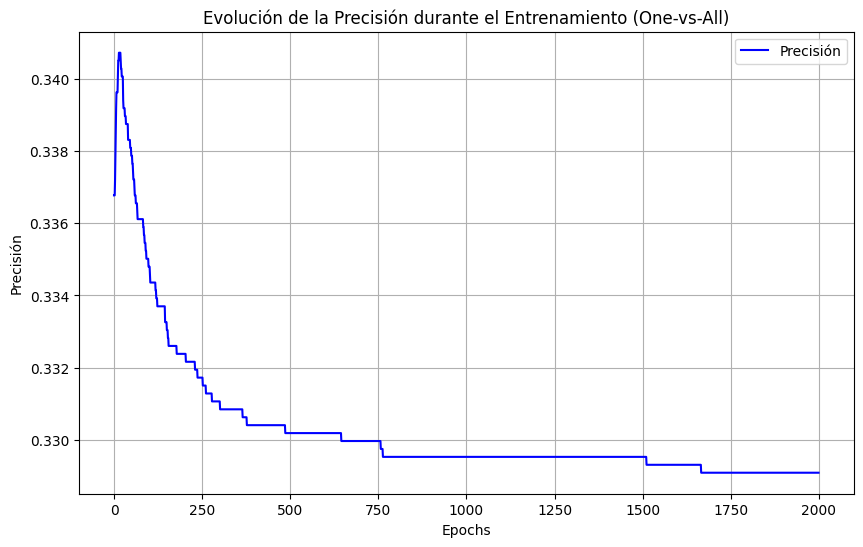

In [129]:
# Supongamos que tienes X_train, y_train
theta_inicial = np.zeros(lCR.X_train.shape[1])
learning_rate = 0.1
epochs = 2000

# Llamar a la función de descenso por gradiente
theta_final, precisiones = des_gradiente(lCR.X_train, lCR.y_train, theta_inicial, learning_rate, epochs)

# Graficar la precisión
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), precisiones, label='Precisión', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.title('Evolución de la Precisión durante el Entrenamiento (One-vs-All)')
plt.legend()
plt.grid(True)
plt.show()

**Se debe visualizar de manera obligatorio graficas que muestren el costo y la precisión en relación a los epochs de entrenamiento.**

**GRAFICA DEL MODELO DE REGRESION LOGISTICA ONE VS ALL**

In [130]:
# Gradiente de la regresión logística
def calcular_gradiente(X, y, theta):
    m = len(y)
    h = oCR.funcionSigmoide(X @ theta)
    gradiente = (1 / m) * (X.T @ (h - y))
    return gradiente

# Función para entrenar un clasificador
def entrenar_clasificador(X, y, theta_inicial, alpha, epochs):
    m = len(y)
    theta = theta_inicial.copy()
    costos = []

    for i in range(epochs):
        costo = calcular_costo(X, y, theta)
        gradiente = calcular_gradiente(X, y, theta)
        theta -= alpha * gradiente
        costos.append(costo)  # Guardar el costo en cada epoch
    return theta, costos

# One-vs-All para múltiples clases
def one_vs_all(X, y, num_etiquetas, alpha, epochs):
    n = X.shape[1]  # Número de características
    all_theta = np.zeros((num_etiquetas, n))
    all_costos = []

    for i in range(num_etiquetas):
        y_bin = np.where(y == i, 1, 0)  # Convertir etiquetas a 1 para la clase actual, 0 para las otras
        theta_inicial = np.zeros(n)
        theta, costos = entrenar_clasificador(X, y_bin, theta_inicial, alpha, epochs)
        all_theta[i, :] = theta
        all_costos.append(costos)

    return all_theta, all_costos



In [131]:
# Función para hacer predicciones con One-vs-All
def predecir_one_vs_all(X, all_theta):
    pred = oCR.funcionSigmoide(X @ all_theta.T)
    return np.argmax(pred, axis=1)  # Retornar la clase con la mayor probabilidad

# Función para calcular la precisión
def calcular_precision(y_real, y_pred):
    precision = np.mean(y_real == y_pred) * 100
    return precision


In [132]:
   # Función para graficar los costos por cada clasificador
def graficar_costos_por_clase(all_costos, num_etiquetas, epochs):
    for i in range(num_etiquetas):
        plt.plot(range(epochs), all_costos[i], label=f'Clase {i}')

    plt.xlabel('Epochs')
    plt.ylabel('Costo')
    plt.title('Costo por clase en cada epoch (One-vs-All)')
    plt.legend()
    plt.grid(True)
    plt.show()

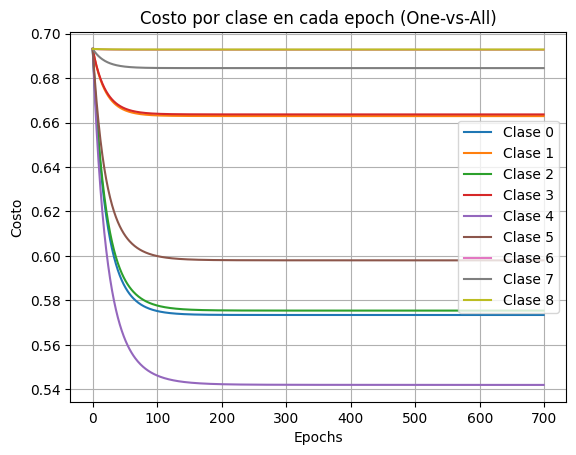

Precisión en entrenamiento: 60.62%
Precisión en prueba: 62.66%


In [133]:
# Parámetros del modelo
lambda_ = 0.1
alpha = 0.1  # Tasa de aprendizaje
epochs = 700  # Número de iteraciones
num_etiquetas = len(np.unique(oCR.y_train))  # Número de clases diferentes

# Entrenamiento del modelo
all_theta, all_costos = one_vs_all(oCR.X_train, oCR.y_train, num_etiquetas, alpha, epochs)

# Gráfica de los costos
graficar_costos_por_clase(all_costos, num_etiquetas, epochs)

# Predicciones y precisión
y_pred_train = predecir_one_vs_all(oCR.X_train, all_theta)
precision_train = calcular_precision(oCR.y_train, y_pred_train)

y_pred_test = predecir_one_vs_all(oCR.X_test, all_theta)
precision_test = calcular_precision(oCR.y_test, y_pred_test)

print(f'Precisión en entrenamiento: {precision_train:.2f}%')
print(f'Precisión en prueba: {precision_test:.2f}%')


**Entrenamiento de los pesos para el modelod de Regresion Logistica One vs All**

In [134]:
# Definir los hiperparámetros
alpha = 0.1  # Tasa de aprendizaje
epochs = 700  # Número de iteraciones para el entrenamiento
num_clases = len(np.unique(oCR.y_train))  # Número de clases diferentes en el dataset

# Entrenamos los pesos para cada clase usando el dataset de entrenamiento
all_theta, all_costos = one_vs_all(oCR.X_train, oCR.y_train, num_clases, alpha, epochs)

# Predicciones en el dataset de entrenamiento
y_pred_train = predecir_one_vs_all(oCR.X_train, all_theta)


precision_entrenamiento = calcular_precision(oCR.y_train, y_pred_train)
print(f'Precisión en el conjunto de entrenamiento: {precision_entrenamiento:.2f}%')


Precisión en el conjunto de entrenamiento: 60.62%


**EFECTIVIDAD DEL MODELO CON EL DATASET DE PRUEBAS**

In [135]:
# Realizamos predicciones en el dataset de prueba usando el modelo One-vs-All
y_pred_test = predecir_one_vs_all(oCR.X_test, all_theta)
precision_prueba = calcular_precision(oCR.y_test, y_pred_test)
print(f'Precisión en el conjunto de prueba: {precision_prueba:.2f}%')

Precisión en el conjunto de prueba: 62.66%


**FUNCIONES BASICAS APARTIR DE LA LIBRERIA NUMPY**

**De debe utilizar código con funciones básicas y construidas todas a partir de la librería numpy. Es decir, no se puede utilizar ninguna otra librería para la construcción de los modelos.**

**Creando el dataset sintetico**

**1.      Insertando atributos que contengan, caracteres, texto, valores booleanos relacionados a la temática del dataset elegido.**

In [136]:
# Cargar el dataset original en un array de numpy
# Cargar el dataset original
dataset = pd.read_csv(r"E:\5to_Semestre\IA_InteligenciaArticifial\Primer_Parcial-SIS420\train.csv")

columns_to_drop = ['Patient Id', 'Patient First Name', 'Family Name', "Father's name", 'Institute Name', 'Location of Institute', 'Gender', 'Inherited from father', 'Maternal gene', 'Parental consent', 'Folic acid details (peri-conceptional)', 'H/O serious maternal illness', 'Assisted conception IVF/ART', 'History of anomalies in previous pregnancies']

# Elimina las columnas
original_dataset = dataset.drop(columns=columns_to_drop)

#elimina las filas que tengan al menos un valor nulo
original_dataset = original_dataset.dropna()


In [137]:
print(original_dataset.shape)

(5702, 31)


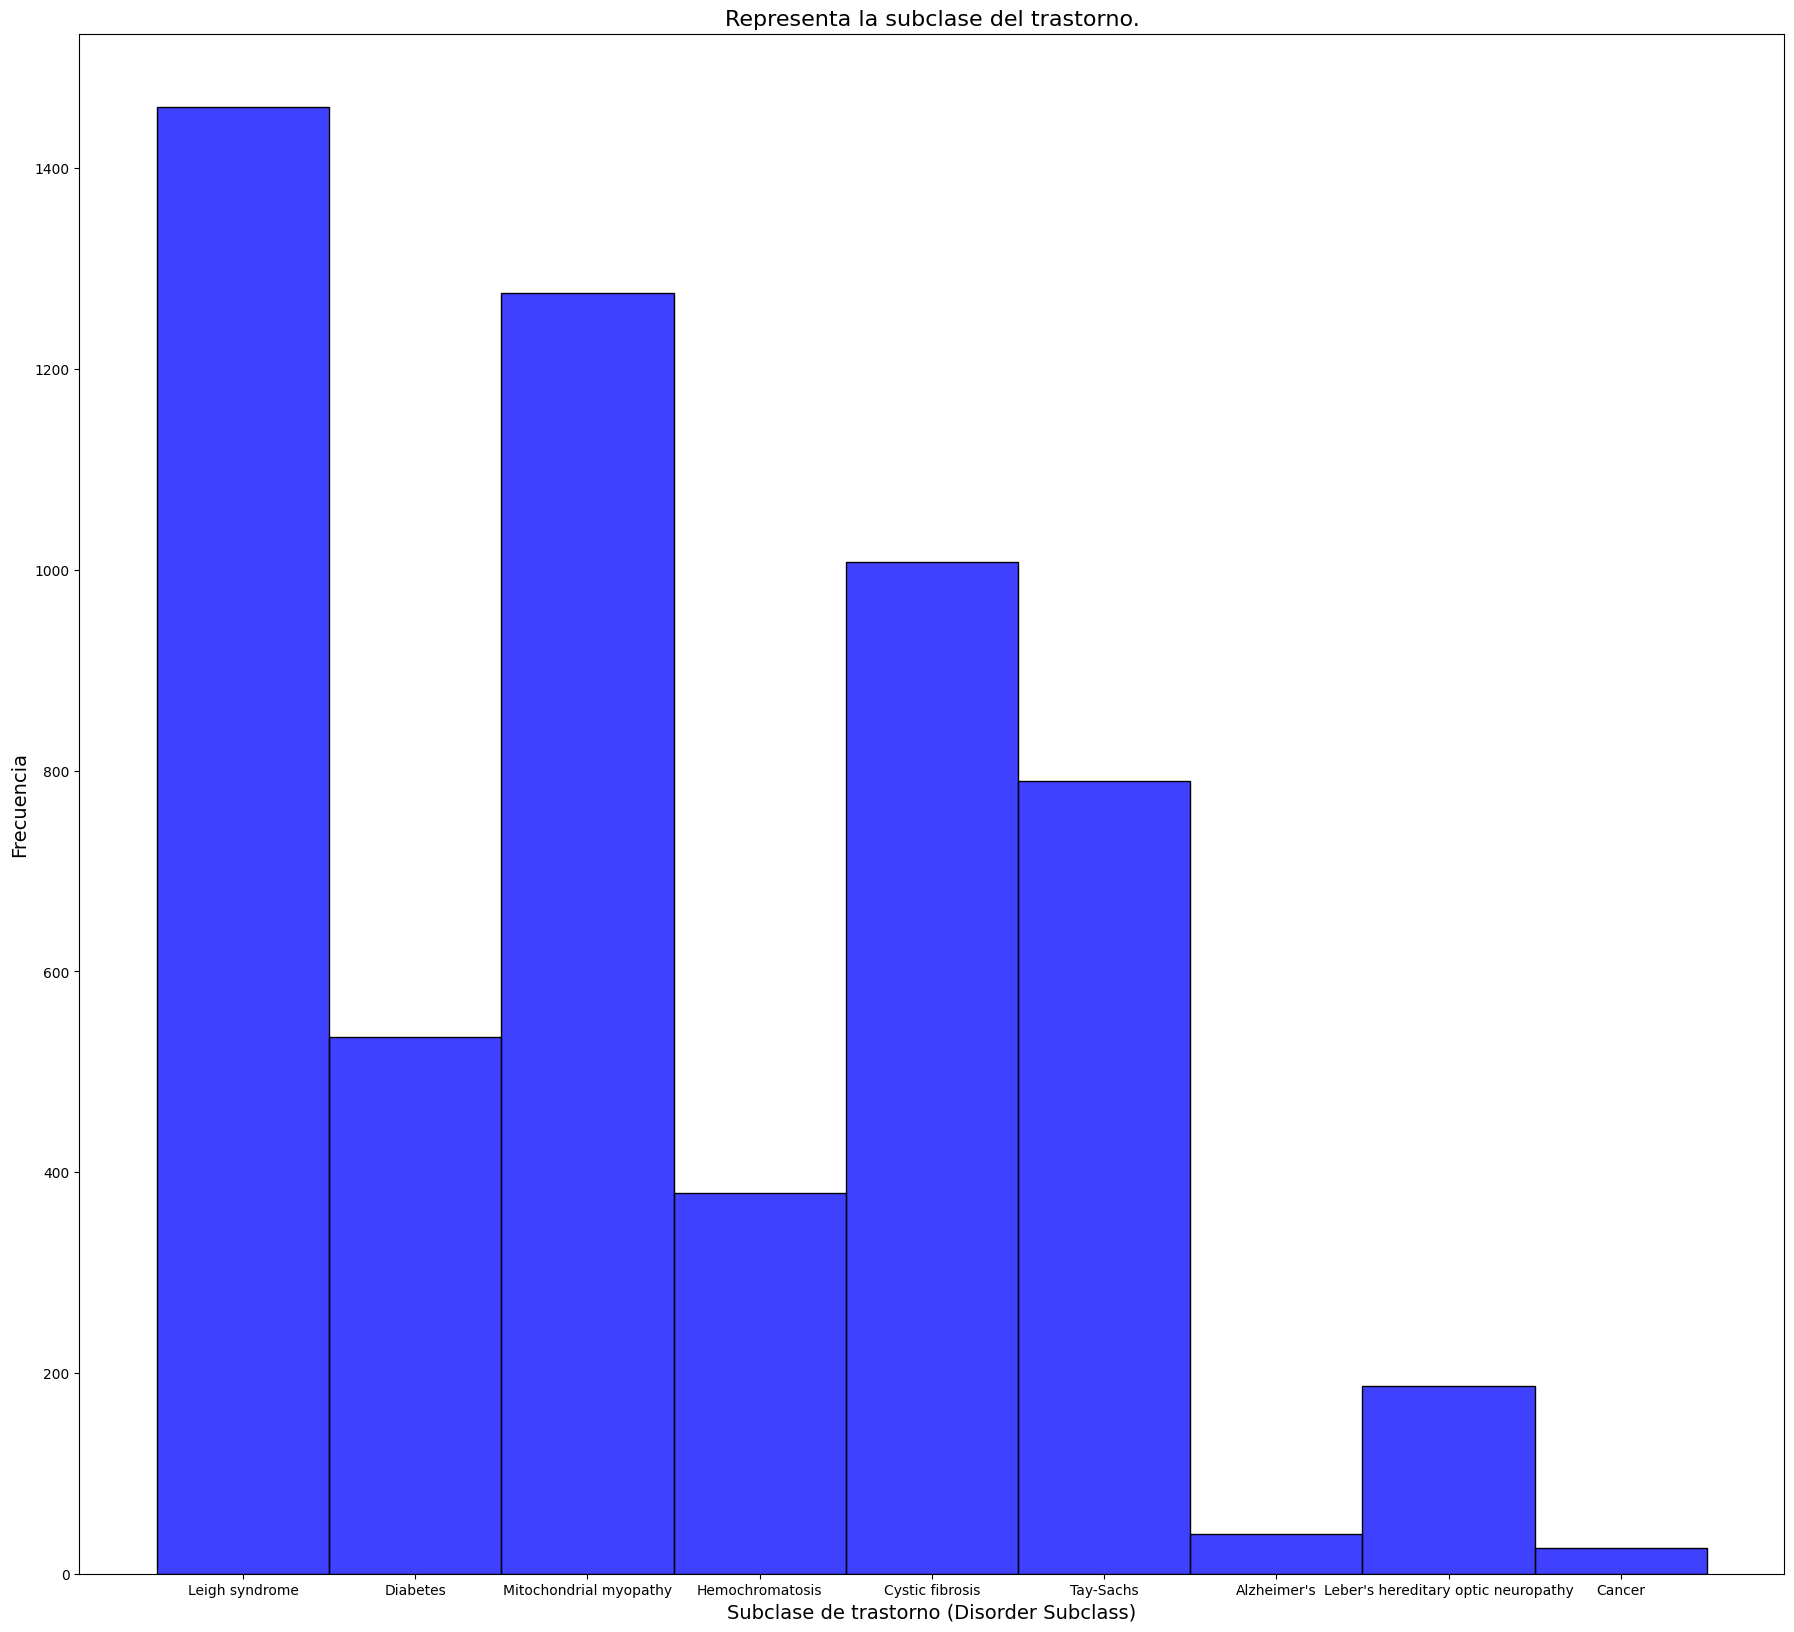

In [138]:
# Crear el histograma para la variable dependiente 'Disorder Subclass'
plt.figure(figsize=(22, 20))
sns.histplot(original_dataset['Disorder Subclass'], bins=10, kde=False, color='blue')

# Añadir etiquetas y título
plt.title('Representa la subclase del trastorno.', fontsize=16)
plt.xlabel('Subclase de trastorno (Disorder Subclass)', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Mostrar la gráfica
plt.show()

In [139]:
# Crear un nuevo dataframe para el dataset sintético
synthetic_dataset = original_dataset.copy()

# Generar atributos de texto relacionados con desórdenes genéticos
temas = ['Síndrome de Down', 'Fibrosis Quística', 'Anemia de Células Falciformes']
synthetic_dataset['desorden_genetico',] = [random.choice(temas) for _ in range(len(synthetic_dataset))]

# Generar atributos de caracteres (por ejemplo, códigos de desórdenes)
synthetic_dataset['codigo_desorden'] = [chr(random.randint(65, 90)) + str(random.randint(0, 9)) for _ in range(len(synthetic_dataset))]

# Generar atributos booleanos (por ejemplo, si el desorden es hereditario)
synthetic_dataset['es_hereditario'] = np.random.choice([True, False], size=len(synthetic_dataset))
synthetic_dataset['requiere_tratamiento_continuo'] = np.random.choice([True, False], size=len(synthetic_dataset))
synthetic_dataset['afecta_varias_generaciones'] = np.random.choice([True, False], size=len(synthetic_dataset))

# Guardar el dataset sintético
synthetic_dataset.to_csv(r"E:\5to_Semestre\IA_InteligenciaArticifial\Primer_Parcial-SIS420\synthetic.csv", index=False)

In [140]:
# Comprobar valores nulos en ambos datasets
print("Valores nulos en el dataset original:\n", original_dataset.isnull().sum())
print("Valores nulos en el dataset sintético:\n", synthetic_dataset.isnull().sum())


Valores nulos en el dataset original:
 Patient Age                                         0
Genes in mother's side                              0
Paternal gene                                       0
Blood cell count (mcL)                              0
Mother's age                                        0
Father's age                                        0
Status                                              0
Respiratory Rate (breaths/min)                      0
Heart Rate (rates/min                               0
Test 1                                              0
Test 2                                              0
Test 3                                              0
Test 4                                              0
Test 5                                              0
Follow-up                                           0
Birth asphyxia                                      0
Autopsy shows birth defect (if applicable)          0
Place of birth                             

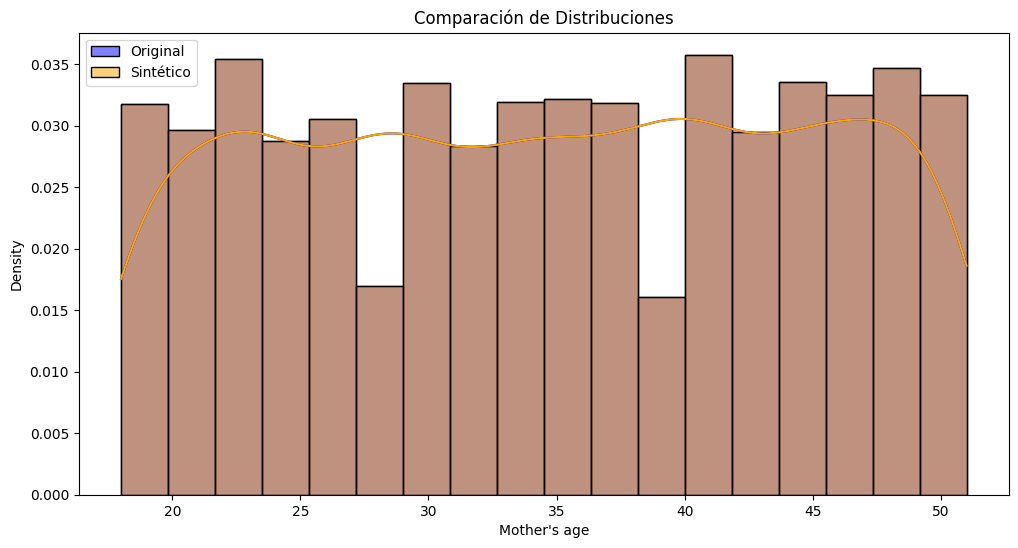

In [141]:
# Ejemplo: comparar una variable numérica
plt.figure(figsize=(12, 6))
sns.histplot(original_dataset["Mother's age"], kde=True, label='Original', color='blue', stat='density', alpha=0.5)
sns.histplot(synthetic_dataset["Mother's age"], kde=True, label='Sintético', color='orange', stat='density', alpha=0.5)
plt.legend()
plt.title('Comparación de Distribuciones')
plt.show()


In [142]:
# Duplicar el dataset
duplicated_data = synthetic_dataset.copy()


# Duplicar ejemplos
duplicated_data = pd.concat([synthetic_dataset]*2, ignore_index=True)

# Concatenar el dataset original y el dataset duplicado
final_data = duplicated_data

# Guardar el nuevo dataset en un archivo
final_data.to_csv(r"E:\5to_Semestre\IA_InteligenciaArticifial\Primer_Parcial-SIS420\final.csv", index=False)

print("Dataset duplicado con nuevos atributos creado con éxito.")

Dataset duplicado con nuevos atributos creado con éxito.


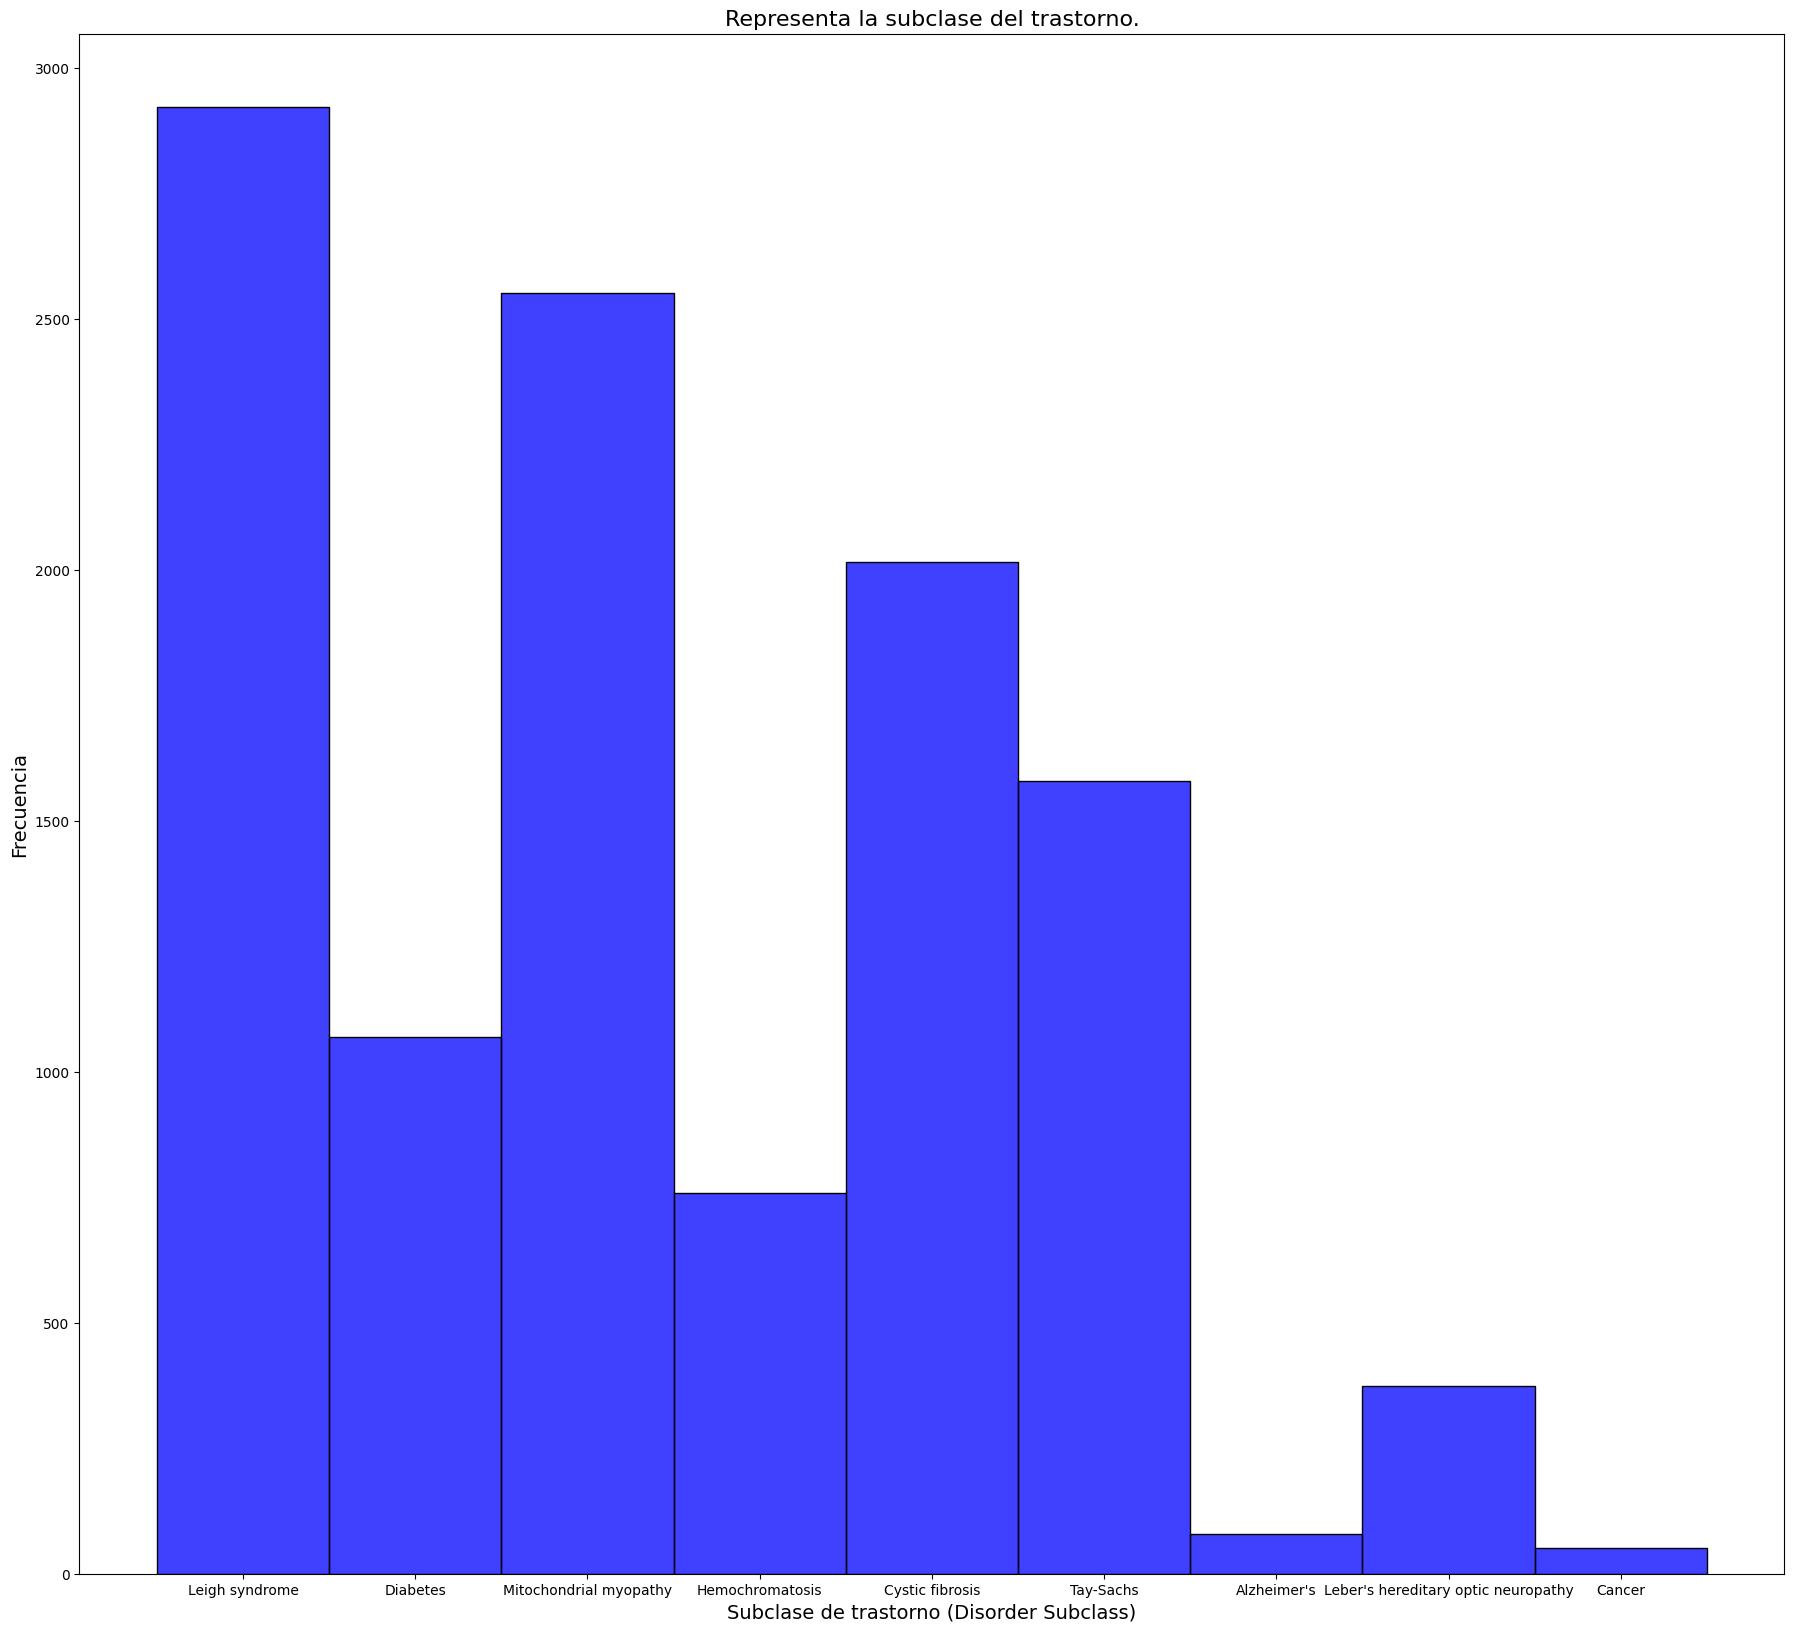

In [143]:
# Cargar el dataset
file_path = r"E:\5to_Semestre\IA_InteligenciaArticifial\Primer_Parcial-SIS420\final.csv"
df = pd.read_csv(file_path)

# Crear el histograma para la variable dependiente 'Disorder Subclass'
plt.figure(figsize=(22, 20))
sns.histplot(df['Disorder Subclass'], bins=10, kde=False, color='blue')

# Añadir etiquetas y título
plt.title('Representa la subclase del trastorno.', fontsize=16)
plt.xlabel('Subclase de trastorno (Disorder Subclass)', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Mostrar la gráfica
plt.show()

**Dividir los datos del dataset sintético en datos de entrenamiento y prueba**

In [144]:
from sklearn.model_selection import train_test_split

# División de los datos
train, test = train_test_split(final_data, test_size=0.2, random_state=42) # Definir el tamaño del conjunto de prueba

print(f'Tamaño del conjunto de entrenamiento: {len(train)}')
print(f'Tamaño del conjunto de prueba: {len(test)}')



Tamaño del conjunto de entrenamiento: 9123
Tamaño del conjunto de prueba: 2281


In [145]:
#ver información de los datos
print(train.shape)
print(test.shape)

(9123, 36)
(2281, 36)


In [146]:
#para X se toman todas las columnas menos la ultima
#para y se toma la ultima columna
# Dividir los datos en conjuntos de entrenamiento y prueba
print(train.shape)
X_train, y_train = train.iloc[:, :-1], train['Disorder Subclass']
X_test, y_test = test.iloc[:, :-1], test['Disorder Subclass']
X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
X_test = np.concatenate([np.ones((X_test.shape[0], 1)), X_test], axis=1)

m = y_train.size

# Mostramos la cantidad de ejemplos que tienen X_train y y_train
print('-' * 80)
print("El 80% de ejemplos que seran para el entrenamiento son: {:.0f}".format(len(train)))
print("El 20% de ejemplos que seran para el test son: {:.0f}".format(len(test)))

(9123, 36)
--------------------------------------------------------------------------------
El 80% de ejemplos que seran para el entrenamiento son: 9123
El 20% de ejemplos que seran para el test son: 2281


In [147]:
print(X_train)

[[1.0 4.0 'No' ... 'S8' True True]
 [1.0 3.0 'Yes' ... 'Y8' False True]
 [1.0 3.0 'Yes' ... 'Y1' False True]
 ...
 [1.0 11.0 'No' ... 'S6' True True]
 [1.0 8.0 'No' ... 'T3' True True]
 [1.0 10.0 'Yes' ... 'V0' False True]]


In [148]:
print(original_dataset['Disorder Subclass'])

8                Leigh syndrome
9                      Diabetes
14               Leigh syndrome
18       Mitochondrial myopathy
19              Hemochromatosis
                  ...          
22054            Leigh syndrome
22056            Leigh syndrome
22057    Mitochondrial myopathy
22066            Leigh syndrome
22068                  Diabetes
Name: Disorder Subclass, Length: 5702, dtype: object


In [149]:
#contar cuantas Clases de Transtornos hay de cada tipo
unique, counts = np.unique(original_dataset['Disorder Subclass'].astype(str), return_counts=True)
print(dict(zip(unique, counts)))

{"Alzheimer's": np.int64(40), 'Cancer': np.int64(26), 'Cystic fibrosis': np.int64(1008), 'Diabetes': np.int64(535), 'Hemochromatosis': np.int64(379), "Leber's hereditary optic neuropathy": np.int64(187), 'Leigh syndrome': np.int64(1461), 'Mitochondrial myopathy': np.int64(1276), 'Tay-Sachs': np.int64(790)}


In [150]:
def calcularSigmoide(z):
    return 1.0 / (1.0 + np.exp(-z))

# Función de coste con regularización
def calcularCosto(theta, X, y, lambda_):
    m = len(y)
    h = calcularSigmoide(X @ theta)
    reg_term = (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))
    J = (-1 / m) * (np.dot(y, np.log(h)) + np.dot((1 - y), np.log(1 - h))) + reg_term

    grad = (1 / m) * X.T @ (h - y)
    grad[1:] += (lambda_ / m) * theta[1:]

    return J, grad

In [151]:
# Gradiente descendente que guarda el coste y la precisión en cada epoch
def gradient_descent(X, y, theta, lambda_, alpha, num_iters):
    m = len(y)
    J_history = []
    accuracy_history = []

    for _ in range(num_iters):
        J, grad = calcularCosto(theta, X, y, lambda_)
        theta -= alpha * grad
        J_history.append(J)  # Guardar el costo en cada epoch

        # Calcular y guardar la precisión en el conjunto de entrenamiento
        predictions = calcularSigmoide(X @ theta) >= 0.5
        accuracy = np.mean(predictions == y) * 100
        accuracy_history.append(accuracy)

    return theta, J_history, accuracy_history

In [152]:
# Regresión logística binaria para cada clase
def binary_logistic_regression(X, y, num_labels, lambda_, alpha, num_iters):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n))
    all_J_history = []  # Para guardar el historial de costo por clase
    all_accuracy_history = []  # Para guardar el historial de precisión por clase

    # Entrenamos un modelo de regresión logística binaria para cada clase
    for i in range(num_labels):
        initial_theta = np.zeros(n)
        y_i = (y == i+1).astype(int)  # Crear etiquetas binarias para la clase i
        theta, J_history, accuracy_history = gradient_descent(X, y_i, initial_theta, lambda_, alpha, num_iters)
        all_theta[i] = theta
        all_J_history.append(J_history)  # Guardar historial de costo
        all_accuracy_history.append(accuracy_history)  # Guardar historial de precisión

    return all_theta, all_J_history, all_accuracy_history

In [153]:
# Predicción
def predict_binary(all_theta, X):
    probabilities = calcularSigmoide(X @ all_theta.T)
    return np.argmax(probabilities, axis=1) + 1  # Clase con la mayor probabilidad

In [154]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)

    sigma[sigma == 0] = 1  # verificar

    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [155]:
# Normalizar las características
X_train = pd.DataFrame(X_train)
X_train = X_train.select_dtypes(include=[np.number])  # Solo columnas numéricas


X_test = pd.DataFrame(X_test)
X_test = X_test.select_dtypes(include=[np.number])  # Solo columnas numéricas

In [156]:
# Normalizar las características

X_train_norm, mu, sigma = featureNormalize(X_train)
X_test_norm = (X_test - mu) / sigma

# Se anade una columna de unos a X train y X test
X_train = np.hstack([np.ones((X_train_norm.shape[0], 1)), X_train_norm])
X_test = np.hstack([np.ones((X_test_norm.shape[0], 1)), X_test_norm])

In [157]:
m, n = X_train_norm.shape

print(f"m (número de filas): {m}")
print(f"n (número de columnas): {n}")

m (número de filas): 9123
n (número de columnas): 0


In [158]:
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_ready: {X_train.shape}")

Shape of y_train: (9123,)
Shape of X_ready: (9123, 1)


In [159]:
# Parámetros del modelo
num_labels = len(np.unique(y_train))  # Número de clases
lambda_ = 0.1
alpha = 0.01
num_iters = 100

# Realizar el entrenamiento y obtener el historial de costo y precisión
all_theta, all_J_history, all_accuracy_history = binary_logistic_regression(X_train, y_train, num_labels, lambda_, alpha, num_iters)
train_pred = predict_binary(all_theta, X_train)
train_accuracy = np.mean(train_pred == y_train) * 100
print(f'Precisión en conjunto de entrenamiento: {train_accuracy:.2f}%')

Precisión en conjunto de entrenamiento: 0.00%


In [160]:
# Realizar las predicciones para el conjunto de prueba
test_pred = predict_binary(all_theta, X_test)
test_accuracy = np.mean(test_pred == y_test) * 100
print(f'Precisión en conjunto de prueba: {test_accuracy:.2f}%')

Precisión en conjunto de prueba: 0.00%


In [161]:
# Seleccionar las primeras 20 datos de prueba
random_indices = np.random.choice(X_test.shape[0], 20, replace=False)

X_test_20 = X_test[random_indices]

# Hacer predicciones sobre esas 20 muestras
test_pred_20 = predict_binary(all_theta, X_test_20)


# Seleccionar las primeras 10 etiquetas reales
test_y_20 = y_test.iloc[random_indices]

comparacion = pd.DataFrame({
    'Valor Real': test_y_20.astype(int),
    'Valor Predicho': test_pred_20
})


# Crear la tabla con HTML
tablaOne = comparacion.to_html(classes="table table-striped table-bordered", index=False)

# Mostrar la tabla con estilo CSS adicional
display(HTML(tablaOne))

# Calcular el porcentaje de acierto
accuracy_20 = np.mean(test_pred_20 == test_y_20) * 100

# Mostrar el porcentaje de acierto
print(f'Porcentaje de acierto en las primeras 20 predicciones: {accuracy_20:.2f}%')

# Contar cuántas predicciones acertaron
aciertos_20 = np.sum(test_pred_20 == test_y_20)

# Mostrar el número de aciertos
print(f'Número de predicciones acertadas en las primeras 20 muestras: {aciertos_20}')


ValueError: invalid literal for int() with base 10: 'Leigh syndrome'

In [ ]:
 # Función para graficar los costos por cada clasificador
def graficar_costos_por_clase(all_costos, num_etiquetas, epochs):
    for i in range(num_etiquetas):
        plt.plot(range(epochs), all_costos[i], label=f'Clase {i}')

    plt.xlabel('Epochs')
    plt.ylabel('Costo')
    plt.title('Costo por clase en cada epoch (One-vs-All)')
    plt.legend()
    plt.grid(True)
    plt.show()

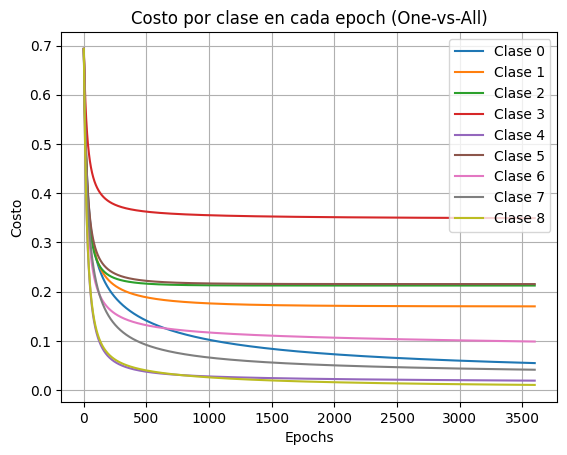

Precisión en entrenamiento: 86.06%
Precisión en prueba: 86.03%


In [191]:
# Parámetros del modelo
alpha = 0.1  # Tasa de aprendizaje
epochs = 2600  # Número de iteraciones
num_etiquetas = len(np.unique(oCR.y_train))  # Número de clases diferentes

# Entrenamiento del modelo
all_theta, all_costos = one_vs_all(X_train, y_train, num_etiquetas, alpha, epochs)

# Gráfica de los costos
graficar_costos_por_clase(all_costos, num_etiquetas, epochs)

# Predicciones y precisión
y_pred_train = predecir_one_vs_all(X_train, all_theta)
precision_train = calcular_precision(y_train, y_pred_train)

y_pred_test = predecir_one_vs_all(X_test, all_theta)
precision_test = calcular_precision(y_test, y_pred_test)

print(f'Precisión en entrenamiento: {precision_train:.2f}%')
print(f'Precisión en prueba: {precision_test:.2f}%')

In [316]:
def cost_function(theta, X, y, lambda_):
    m = len(y)
    h = calcularSigmoide(X @ theta)
    reg_term = (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))
    J = (-1 / m) * (np.dot(y, np.log(h)) + np.dot((1 - y), np.log(1 - h))) + reg_term

    grad = (1 / m) * X.T @ (h - y)
    grad[1:] += (lambda_ / m) * theta[1:]

    return J, grad

def gradient_descent(X, y, theta, lambda_, alpha, num_iters):
    J_history = []

    for _ in range(num_iters):
        J, grad = cost_function(theta, X, y, lambda_)
        theta = theta - alpha * grad
        J_history.append(J)

    return theta, J_history

In [59]:
def one_vs_all(X, y, num_labels, lambda_, alpha, num_iters):
    n = X.shape[1]
    all_theta = np.zeros((num_labels, n))
    all_J_history = []  # Lista para almacenar los historiales de costos

    for i in range(num_labels):
        initial_theta = np.zeros(n)
        y_i = (y == i + 1).astype(int)
        theta, J_history = gradient_descent(X, y_i, initial_theta, lambda_, alpha, num_iters)
        all_theta[i] = theta
        all_J_history.append(J_history)  # Guardar el historial de costos para esta clase

    return all_theta, all_J_history  # Retorna all_J_history en lugar de J_history

In [318]:
# Función para predecir
def predict_one_vs_all(all_theta, X):
    return np.argmax(calcularSigmoide(X @ all_theta.T), axis=1) + 1

In [365]:
# Parámetros para el entrenamiento
num_labels = len(np.unique(y_train))
lambda_ = 0.1
alpha = 0.01
num_iters = 2600
all_theta, all_J_history = one_vs_all(X_train, y_train, num_labels, lambda_, alpha, num_iters)
J_train, _ = cost_function(all_theta[0], X_train, (y_train == 1).astype(int), lambda_)
print(f'Costo en el conjunto de entrenamiento : {J_train:.4f}')

TypeError: one_vs_all() takes 5 positional arguments but 6 were given

In [165]:
J_test, _ = cost_function(all_theta[0], X_test, (y_test == 1).astype(int), lambda_)
print(f'Costo en el conjunto de prueba : {J_test:.4f}')

Costo en el conjunto de prueba : 0.2158


In [166]:
# Calcular la precisión en el conjunto de entrenamiento y prueba
train_pred = predict_one_vs_all(all_theta, X_train)
train_accuracy = np.mean(train_pred == y_train) * 100
print(f'Precisión en conjunto de entrenamiento: {train_accuracy:.2f}%')

Precisión en conjunto de entrenamiento: 69.02%


In [225]:
test_pred = predict_one_vs_all(all_theta, X_test)
test_accuracy = np.mean(test_pred == y_test) * 100
print(f'Precisión en conjunto de prueba: {test_accuracy:.2f}%')

Precisión en conjunto de prueba: 8.13%


In [170]:
# Seleccionar las primeras 20 datos de prueba
random_indices = np.random.choice(X_test.shape[0], 20, replace=False)

X_test_20 = X_test[random_indices]

# Hacer predicciones sobre esas 20 muestras
test_pred_20 = predict_one_vs_all(all_theta, X_test_20)


# Seleccionar las primeras 10 etiquetas reales
test_y_20 = y_test.iloc[random_indices]

comparacion = pd.DataFrame({
    'Valor Real': test_y_20.astype(int),
    'Valor Predicho': test_pred_20
})


# Crear la tabla con HTML
tablaOne = comparacion.to_html(classes="table table-striped table-bordered", index=False)

# Mostrar la tabla con estilo CSS adicional
display(HTML(tablaOne))

# Calcular el porcentaje de acierto
accuracy_20 = np.mean(test_pred_20 == test_y_20) * 100

# Mostrar el porcentaje de acierto
print(f'Porcentaje de acierto en las primeras 20 predicciones: {accuracy_20:.2f}%')

# Contar cuántas predicciones acertaron
aciertos_20 = np.sum(test_pred_20 == test_y_20)

# Mostrar el número de aciertos
print(f'Número de predicciones acertadas en las primeras 20 muestras: {aciertos_20}')

Valor Real,Valor Predicho
3,3
3,3
3,3
4,5
0,3
3,3
7,7
7,7
2,1
1,1


Porcentaje de acierto en las primeras 20 predicciones: 70.00%
Número de predicciones acertadas en las primeras 20 muestras: 14


Epoch 0: Costo = -0.9715, Precisión = 0.1030
Epoch 100: Costo = -82.2561, Precisión = 0.1094
Epoch 200: Costo = -84.7192, Precisión = 0.1097
Epoch 300: Costo = -83.8066, Precisión = 0.1099
Epoch 400: Costo = -83.1527, Precisión = 0.1100
Epoch 500: Costo = -82.7288, Precisión = 0.1100
Epoch 600: Costo = -82.4413, Precisión = 0.1100


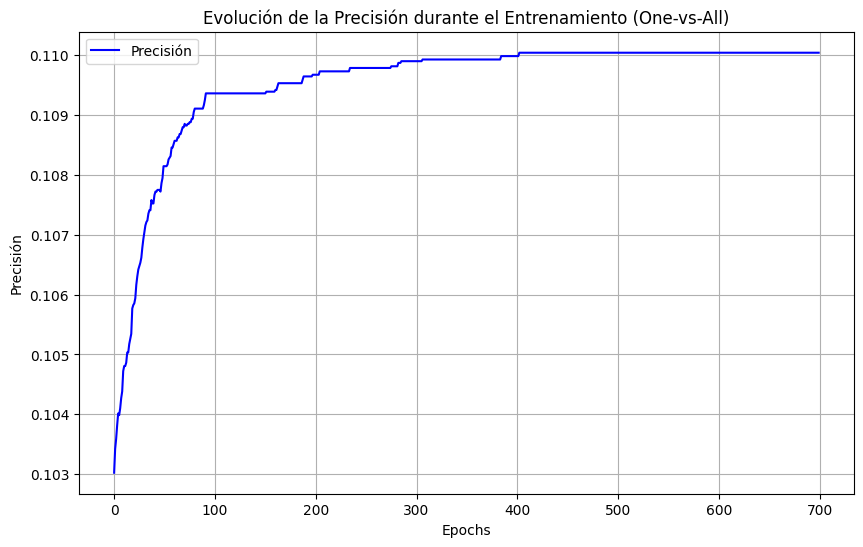

In [380]:
# Supongamos que tienes X_train, y_train
theta_inicial = np.zeros(X_train.shape[1])
learning_rate = 0.1
epochs = 700

# Llamar a la función de descenso por gradiente
theta_final, precisiones = des_gradiente(X_train, y_train, theta_inicial, learning_rate, epochs)

# Graficar la precisión
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), precisiones, label='Precisión', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.title('Evolución de la Precisión durante el Entrenamiento (One-vs-All)')
plt.legend()
plt.grid(True)
plt.show()